
# ENA Data Browse Images

This notebook is for playing around with plots and images for the ENA Data Browser. I will use this notebook to figure out what kind of plots I want to show and how I want to show them. 

## Types of Plots

This is a preliminary list of things that would be useful to see in a daily view of the ENA site.

* Composite windrose of speed and direction for the day
* Timeseries of precipitation
* RADAR/LIDAR timeseries
* Skew-T charts of available soundings
* Timeseries of CCN at different supersaturation levels
* Synoptic maps from ECMWF with wind and slp (maybe upper level, say 500mb?)
* Satellite imagery

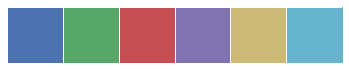

In [1]:
import matplotlib.pyplot as plt

import toolbox as tbx
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import glob
import os

from mpl_toolkits.basemap import Basemap

import seaborn as sns
colors = sns.color_palette()
sns.palplot(colors)

In [2]:
sample_date = datetime.datetime(2014, 10, 10)
date = sample_date.strftime('%Y-%m-%d')
print(date)

2014-10-10


## Data Sources
Define sources for the different datastreams

In [3]:
# set the base directory
base_directory = os.path.abspath('/Volumes/data/ENA/')
if not os.path.isdir(base_directory):
    base_directory = os.path.abspath('/Volumes/NiftyDrive/Research/data/ENA/')

support_directory = os.path.join(os.getenv("HOME"), 'Documents/htdocs/ena_data_browser/support-files')
plot_directory = os.path.join(os.getenv("HOME"), 'Documents/htdocs/ena_data_browser/support-files/figures')

# Surface Meteorology
sfcmet = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'met'))
sfcmet.summary()

# CCN
ccndat = tbx.fileIO.NetCDFFolder(os.path.join(base_directory, 'ccn'))
ccndat.summary()

/Volumes/NiftyDrive/Research/data/ENA/met
Found 658 files total

Found 658 items for datastream enametC1

/Volumes/NiftyDrive/Research/data/ENA/ccn
Found 609 files total

Found 609 items for datastream enaaosccn100C1



In [4]:
print(sfcmet.filelist[-1])
print(ccndat.filelist[-1])

/Volumes/NiftyDrive/Research/data/ENA/met/enametC1.b1.20150710.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/ccn/enaaosccn100C1.a1.20150520.000000.nc


In [5]:
# start with the surface meteorology stuff, using our sample datetime.
for f in sfcmet.filelist:
    if date.replace('-', '') in f:
        break
    else:
        f = None

for c in ccndat.filelist:
    if date.replace('-', '') in c:
        break
    else:
        c = None

In [6]:
print(f)
print(c)

SFC = tbx.fileIO.NetCDFFile(f)
CCN = tbx.fileIO.NetCDFFile(c)

/Volumes/NiftyDrive/Research/data/ENA/met/enametC1.b1.20141010.000000.cdf
/Volumes/NiftyDrive/Research/data/ENA/ccn/enaaosccn100C1.a1.20141010.000000.cdf


In [7]:
SFCDAT = SFC.get_vars(varlist=['atmos_pressure', 
                               'wspd_vec_mean', 
                               'wdir_vec_mean', 
                               'org_precip_rate_mean',
                               'temp_mean'], 
                       exclude='qc').astype(np.float)

In [8]:
CCNDAT = CCN.get_vars(varlist=['N_CCN', 'ss', 'supersat'], 
                            exclude='qc',
                            mapping={'N_CCN': 'CCN', 
                                     'CCN_supersaturation_set_point': 'SS',
                                     'CCN_ss_set': 'SS'})
#print(set(CCNDAT['CCN_supersaturation_set_point']))

In [9]:
CCN01 = CCNDAT[CCNDAT.SS == 0.1]['CCN'].resample('1Min', how='mean').astype(np.float)
CCN05 = CCNDAT[CCNDAT.SS == 0.8]['CCN'].resample('1Min', how='mean').astype(np.float)

In [10]:
CCN01.name = "CCN01"
CCN05.name = "CCN05"

DATA = SFCDAT.join([CCN01, CCN05])
DATA.fillna(np.float('nan'), inplace=True)

In [11]:
DATA.dtypes

atmos_pressure          float64
org_precip_rate_mean    float64
temp_mean               float64
wdir_vec_mean           float64
wspd_vec_mean           float64
CCN01                   float64
CCN05                   float64
dtype: object

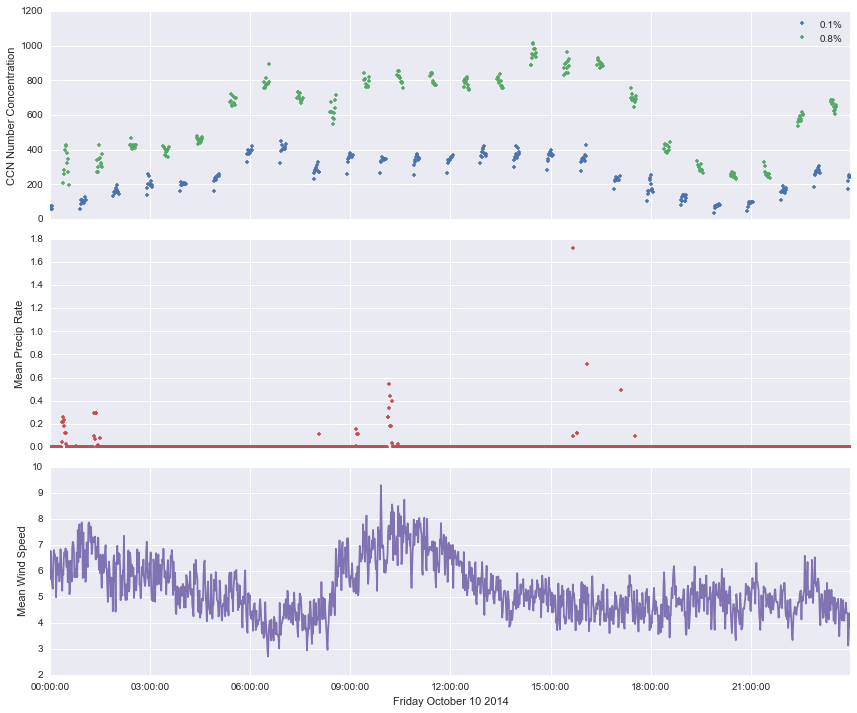

In [12]:
fig, ax = plt.subplots(3, figsize=(12, 10), sharex=True)

ax[0].plot(DATA.index, DATA.CCN01, '.', color=colors[0], label="0.1%")
ax[0].plot(DATA.index, DATA.CCN05, '.', color=colors[1], label="0.8%")
ax[0].set_ylabel("CCN Number Concentration")
ax[0].legend()

ax[1].plot(DATA.index, DATA.org_precip_rate_mean, '.', color=colors[2])
ax[1].set_ylabel("Mean Precip Rate")

ax[2].plot(DATA.index, DATA.wspd_vec_mean, color=colors[3])
ax[2].set_ylabel('Mean Wind Speed')
#fig.autofmt_xdate()

ax[-1].set_xlabel(sample_date.strftime('%A %B %d %Y'))

figout = os.path.join(plot_directory, 'main/')
if not os.path.isdir(figout):
    os.makedirs(figout)

fig.tight_layout()
fig.savefig(os.path.join(figout, date+'.png'), transparent=False)

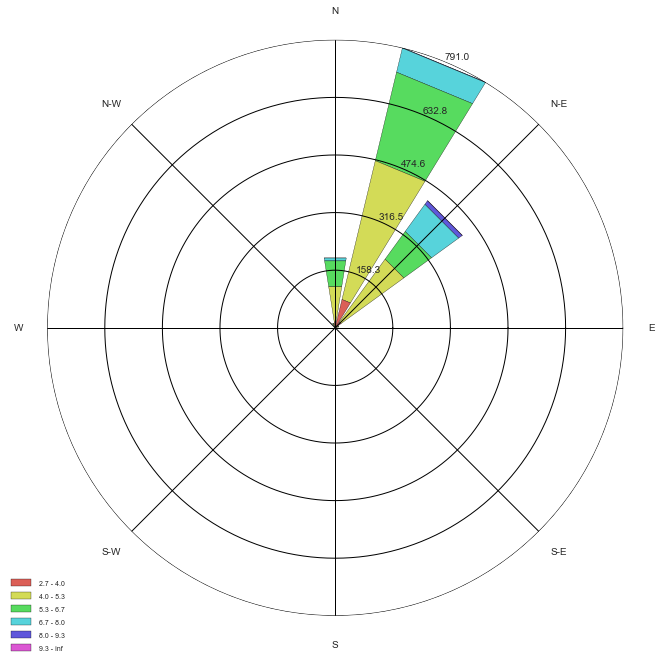

In [13]:
fig, ax = tbx.plotting.windrose(direction=DATA['wdir_vec_mean'], 
                                speed=DATA['wspd_vec_mean'],
                                #bins=[0, 4, 6, 7, 8])
                                colors=sns.color_palette("hls", 6))

figout = os.path.join(plot_directory, 'rose/')
if not os.path.isdir(figout):
    os.makedirs(figout)
    
fig.savefig(os.path.join(figout, date+'.png'))

http://lance-modis.eosdis.nasa.gov/imagery/subsets/?subset=ARM_Azores.2014283.aqua.2km.jpg


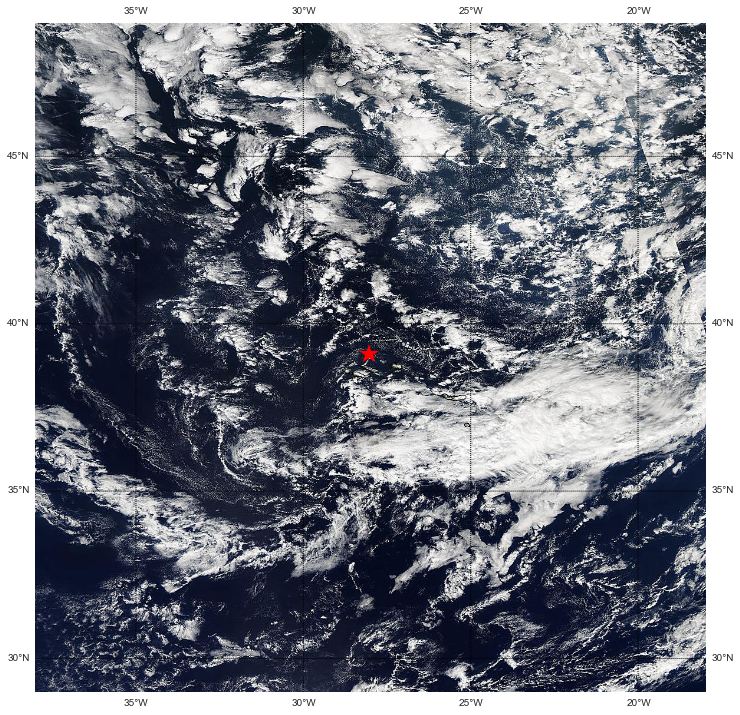

In [14]:
imgsrc = 'http://lance-modis.eosdis.nasa.gov/imagery/subsets/?subset=ARM_Azores.' \
            + sample_date.strftime('%Y%j') \
            + '.aqua.2km.jpg'

#ENA - Graciosa Island, Azores
#39° 5' 29.68" N, 28° 1' 32.34" W 
#Altitude: 30.48 meters

from PIL import Image
import urllib, cStringIO
#from shapelib import ShapeFile

file = cStringIO.StringIO(urllib.urlopen(imgsrc).read())
try:
    img = Image.open(file)
except IOError:
    img = None

print(imgsrc)
fig, ax = plt.subplots(figsize=(12,12))

m = Basemap(llcrnrlat=28.9951, llcrnrlon=-38.0039,
            urcrnrlat=48.9990, urcrnrlon=-18.000,
            resolution='c', ax=ax, area_thresh=0.1)

#m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 5), labels=[1,1,1,1])
m.drawmeridians(np.arange(-180, 180, 5), labels=[1,1,1,1])
if img is not None:
    m.imshow(img, origin='upper')

m.plot(-28.02565, 39.091578, 'r*', markersize=20, latlon=True)

m.readshapefile(os.path.join(support_directory, 'PRT_adm/PRT_adm0'), 'prt', drawbounds=True)

if img is not None:
    img.close()

In [15]:
fig.savefig(plot_directory+'map.png', transparent=False)